参考：https://tf.wiki/zh_hans/basic/basic.html

In [74]:
import tensorflow as tf  # 在tf2中，即时执行模式为默认方式
tf.__version__

'2.2.0'

# 在tf 中使用 张量 作为数据的基本单位
张量的重要属性是 形状、类型 和值


In [22]:
# 定义随机数，标量
random_float= tf.random.uniform(shape=())
random_float

<tf.Tensor: shape=(), dtype=float32, numpy=0.30347502>

In [34]:
# 定义有2个元素的零向量
zero_vector = tf.zeros(shape=(2))
zero_vector

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [32]:
# 定义两个 2x2 的常量矩阵
A= tf.constant([[1.,2.], [3.,4.]])
B= tf.constant([[5.,6.], [7.,8.]])
A,B

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 2.],
        [3., 4.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[5., 6.],
        [7., 8.]], dtype=float32)>)

In [33]:
# 张量的重要属性是 形状、类型 和值
# 查看：
print(A.shape, A.dtype, A.numpy())

(2, 2) <dtype: 'float32'> [[1. 2.]
 [3. 4.]]


In [36]:
# 张量操作
c= tf.add(A,B)  # 计算矩阵和
c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 6.,  8.],
       [10., 12.]], dtype=float32)>

In [37]:
# 计算矩阵相乘
D = tf.matmul(A,B)
D

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[19., 22.],
       [43., 50.]], dtype=float32)>

# 自动求导机制
tf.GradientTape()

In [50]:
# 计算 y(x)= x^2 在x=3时的导数
import tensorflow as tf
x=tf.Variable(initial_value=3.)  # 声明变量, 变量赋值初始化
with tf.GradientTape() as tape:
    y= tf.square(x)
y_grad = tape.gradient(y,x)
y, y_grad, x   #注意，张量与变量的区别

# 变量与普通张量的一个重要区别是其默认能够被 TensorFlow 的自动求导机制所求导，
# 因此往往被用于定义机器学习模型的参数。

(<tf.Tensor: shape=(), dtype=float32, numpy=9.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>)

In [56]:
# 对多元函数、向量、矩阵求导
# 如对 L(w, b) = |Xw + b - y|^2 
# 在 w = (1, 2)^T, b = 1 时分别对 w, b 的偏导数
X = tf.constant([[1., 2.], [3., 4.]])
y = tf.constant([[1.], [2.]])
w = tf.Variable(initial_value=[[1.], [2.]])
b = tf.Variable(initial_value=1.)
with tf.GradientTape() as tape:
    L = tf.reduce_sum(tf.square(tf.matmul(X, w) + b - y))  
    # tf.reduce_sum() 操作代表对输入张量的所有元素求和，输出一个形状为空的纯量张量
#     （可以通过 axis 参数来指定求和的维度，不指定则默认对所有元素求和）
w_grad, b_grad = tape.gradient(L, [w, b])        # 计算L(w, b)关于w, b的偏导数
print(L,'\n', w_grad,'\n', b_grad)

tf.Tensor(125.0, shape=(), dtype=float32) 
 tf.Tensor(
[[ 70.]
 [100.]], shape=(2, 1), dtype=float32) 
 tf.Tensor(30.0, shape=(), dtype=float32)


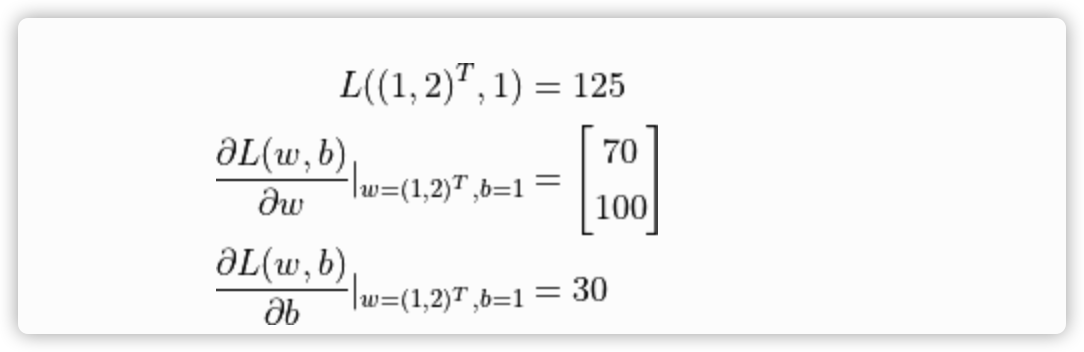

# 基础示例：线性回归

考虑一个实际问题，某城市在 2013 年 - 2017 年的房价如下表所示：

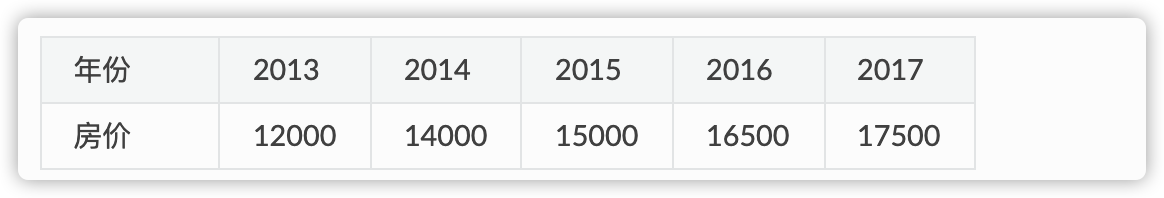
现在，我们希望通过对该数据进行线性回归，即使用线性模型 y = ax + b 来拟合上述数据，此处 a 和 b 是待求的参数。

In [65]:
# 1） 定义数据，进行归一化操作
import numpy as np
X_raw = np.array([2013, 2014, 2015, 2016, 2017], dtype=np.float32)
y_raw = np.array([12000, 14000, 15000, 16500, 17500], dtype=np.float32)

X = (X_raw - X_raw.min()) / (X_raw.max() - X_raw.min())
y = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

损失函数：l = (ax+b-y)^2

In [71]:
# 首先，使用np 手工操作
a, b= 0,0
num_epoch = 10000
learning_rate = 5e-4
for e in range(num_epoch):
    y_pred = a*X+b
    grad_a, grad_b = 2*(y_pred-y).dot(X), 2*(y_pred-y).sum()
    
#     更新参数
    a,b = a-learning_rate*grad_a, b-learning_rate*grad_b
print(a,b)

0.9763702027872223 0.057564988337455304


然而，你或许已经可以注意到，使用常规的科学计算库实现机器学习模型有两个痛点：

经常需要手工求函数关于参数的偏导数。如果是简单的函数或许还好，但一旦函数的形式变得复杂（尤其是深度学习模型），手工求导的过程将变得非常痛苦，甚至不可行。

经常需要手工根据求导的结果更新参数。这里使用了最基础的梯度下降方法，因此参数的更新还较为容易。但如果使用更加复杂的参数更新方法（例如 Adam 或者 Adagrad），这个更新过程的编写同样会非常繁杂。

## TF下的线性回归

In [81]:
X = tf.constant(X)
y = tf.constant(y)

a = tf.Variable(initial_value=0.)
b = tf.Variable(initial_value=0.)
variables = [a, b]

num_epoch = 10000
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-4)  # 声明梯度下降优化器
for e in range(num_epoch):
    # 使用tf.GradientTape()记录损失函数的梯度信息
    with tf.GradientTape() as tape:
        y_pred = a * X + b
        loss = tf.reduce_sum(tf.square(y_pred - y))
    # TensorFlow自动计算损失函数关于自变量（模型参数）的梯度
    grads = tape.gradient(loss, variables)
    # TensorFlow自动根据梯度更新参数
    optimizer.apply_gradients(grads_and_vars=zip(grads, variables))
print(a,b)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.97637> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.057565063>
